**Introduction:** The goal of this project is to predict the medical condition of SEVERAL distinct abdominal organs using only a single slice of the CT scan of the patient. Although the test data is 2D images, the labeled input data of subjects includes all slices from a 3D scan. Minority of the subjects also have segmentation masks available that indicates the position of each organi in their scans. The output labels of the model should be probability of injury for each organ. Note that some of the organs have different levels of injury (healthy/low/high).<br>

**Approach:** Our approach to predict the output labels is to serialize a UNet and 5 parallel CNNs for all organs as follows:
1) A deep neural network with UNet architecture that learns segmentations from the existing subjects, and expands it across all subjects.<br>
2) Once segmentations of all organs of all subjects are extracted from the UNET, raw scans multiplied to the segmentation probabilities (i.e. UNet output) of each organ is fed into a typical CNN architecture (5 in parallel) that outputs the output labels of each organ.<br>

* UNet:       
    - Lr scheduler with cyclic triangular pattern that decays over time
    - Focal Tversky loss function

* CNN:
    - Segmentations are multiplied
    - CNNs are now run on patients not on slices, in other words, each batch consists of patients and each patient has N slices on their first dimension while the last two dims are just image dims. 
    - N (10) equidistant slices are picked across the whole session. If less available, "Nearest" interpolation will be done.
    - Separate CNN with appropriate loss function is designed for each organ
    - BCElosswithlogits is used for organs with only 2 levels of output (healthy/injured)
    - CrossEntropy is used for organs with more than 2 levels of output (healthy/low/high)
    

**Results:** <br>
- The UNet architecture has a decent sensitivity and specificity
- Because CNN loss is a custom function, CNN outputs logits not cross entropy or else. post_proc function translates logits to probs.
- In this approach we won't have an issue of integrating the output labels of all slices into one since it is already integrated in the CNNs
- Importantly, If two sessions are available for a subject, the one with higher HU is used to extract background mask which is for extravasation detection.

# Initializations

In [2]:
import warnings
warnings.filterwarnings('ignore')

import os
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

import sklearn.metrics as metrics

from PIL import Image as im
import cv2
import pydicom as dcm

import torch
import torch.nn as nn
import torch.nn.functional as f
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

import torchvision
import torchvision.transforms.v2 as T
import albumentations as A
from albumentations.core.transforms_interface import DualTransform

from tqdm import tqdm
import gc

In [3]:
# ________________________________________________________________________________________________________________ INITILIZATIONS
def set_device():
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(device)
    return device    

def set_data_paths():
    data_path = {}
    data_path['root'] = '/kaggle/input/rsna-2023-abdominal-trauma-detection'
    data_path['train'] = '/kaggle/input/rsna-2023-abdominal-trauma-detection/train_images'
    data_path['segmentations'] = '/kaggle/input/rsna-2023-abdominal-trauma-detection/segmentations'
    data_path['test'] = '/kaggle/input/rsna-2023-abdominal-trauma-detection/test_images'
    data_path['masks'] = '/kaggle/input/unet256clean-masks-v2/unet256clean_masks/unet256clean_masks'
    data_path['masks_augmented'] = '/kaggle/input/unet256clean-masks-with-augs-spleen/unet256clean-masks_with_augs_Spleen'
    return data_path

def create_segmentation_dict():
    # Mask organ label mapping
    segmentation_dict = {}
    segmentation_dict['segmentation_class_to_inx'] = {'Background': 0, 'Liver': 1, 'Spleen': 2, 'Kidney_left': 3, 'Kidney_right': 4, 'Bowel': 5}
    segmentation_dict['segmentaiton_inx_to_class'] = {0: 'Background', 1: 'Liver', 2:'Spleen', 3:'Kidney_left', 4:'Kidney_right', 5 :'Bowel'}
    segmentation_dict['final_output'] = ['Background', 'Bowel', 'Kidney' , 'Liver' , 'Spleen']
    return segmentation_dict

# ________________________________________________________________________________________________________________ POST-PROCESSING OUTPUT TOOLS

# convert output labels to CNN nodes for targets in training CNN
def convert_pd_to_CNN_targets(patient_list, cfg):
    patient_list['bowel'] = patient_list.apply(lambda x: x['bowel_injury'], axis=1).astype('category')
    patient_list['extravasation'] = patient_list.apply(lambda x: x['extravasation_injury'], axis=1).astype('category')
    patient_list = patient_list.drop(columns=['bowel_injury', 'bowel_healthy', 'extravasation_injury', 'extravasation_healthy', 'any_injury'])
    patient_list = patient_list.iloc[:, -11:]
    patient_list = pd.concat([patient_list.iloc[:, -2:], patient_list.iloc[:, :-2]], axis=1)
    patient_list = patient_list.apply(lambda x: x.astype(np.uint8))
    return patient_list


def convert_CNN_logits_to_probs(CNN_nodeouput, node_labels, is_target=True):
    # change from logits to probs
    if is_target:
        pass
    else:
        CNN_nodeouput[:, [0, 1]] = f.sigmoid(CNN_nodeouput[:, [0, 1]])    
        CNN_nodeouput[:, 2:5] = f.softmax( CNN_nodeouput[:, 2:5], dim=-1)
        CNN_nodeouput[:, 5:8] = f.softmax( CNN_nodeouput[:, 5:8], dim=-1)
        CNN_nodeouput[:, 8:11] = f.softmax( CNN_nodeouput[:, 8:11], dim=-1)
    
    # split bowel and extravasation
    CNN_nodeouput = pd.DataFrame(CNN_nodeouput, columns=node_labels)
    CNN_nodeouput['bowel_healthy'] = 1 - CNN_nodeouput['bowel']
    CNN_nodeouput['bowel_injury'] = CNN_nodeouput['bowel']
    CNN_nodeouput['extravasation_healthy'] = 1 - CNN_nodeouput['extravasation']
    CNN_nodeouput['extravasation_injury'] = CNN_nodeouput['extravasation']
    
    # sort columns appropriately
    cols = list(CNN_nodeouput.columns)
    cols = cols[-4:] + cols[2:-4]
        
    CNN_nodeouput = CNN_nodeouput.loc[:, cols]
    return CNN_nodeouput.astype('float32')

def post_proc(pred):
    proc_pred = torch.empty((pred.shape[0], 2*2 + 3*3)).type(torch.float32)

    pred[:, 0] = f.sigmoid(pred[:, 0])    
    pred[:, 1] = f.sigmoid(pred[:, 1])    
    pred[:, 2:5] = f.softmax( pred[:, 2:5], dim=-1)
    pred[:, 5:8] = f.softmax( pred[:, 5:8], dim=-1)
    pred[:, 8:11] = f.softmax( pred[:, 8:11], dim=-1)
    
    # bowel, extravasation
    proc_pred[:, 0] = 1 - pred[:, 0]
    proc_pred[:, 1] = pred[:, 0]
    proc_pred[:, 2] = 1 - pred[:, 1]
    proc_pred[:, 3] = pred[:, 1]
    
    # liver, kidney, sneel
    proc_pred[:, 4:7] = pred[:, 2:5]
    proc_pred[:, 7:10] = pred[:, 5:8]
    proc_pred[:, 10:13] = pred[:, 8:11]

    return proc_pred

# ________________________________________________________________________________________________________________ RANDOM TOOLS
def one_hot(data, classes=None):
    if classes is None:
        classes = {key: key for key in np.unique(data.flatten())}
        
    outputs = {}
    for key, val in classes.items():
        outputs[key] = (data == val).astype(np.int8)
    return outputs

def imagify_mask(masks):
    image = np.zeros_like(masks[0, :, :])
    for layer in range(masks.shape[0]):
        mask = np.squeeze(masks[layer, :, :])
        
        i, j = np.where(mask == 1)
        image[i, j] = layer + 1
    return image


def triangular_lr(current_step: int, base_lr=0.001, triangle_height=100, triangle_width=400):        
    res = current_step % triangle_width

    div = int(current_step / triangle_width) # 0, 1, 2, ...
    scale = 0.9 ** div # 1, 0.9, 0.8, ...
    triangle_height *= scale
    
    m = triangle_height / (triangle_width/2)

    if res < triangle_width/2:
         factor =  m * (res + 1 - triangle_width/2) + triangle_height
    elif res >= triangle_width/2: 
        res -= triangle_width/2
        factor = -m * res + triangle_height
        
    return max(factor, 1)

# ________________________________________________________________________________________________________________ PLOTTING TOOLS
def visualize_CNN_batch(batch, num_patients_to_plot=1):
    (image_origs, masks, target) = batch

    for patient_index in range(0, num_patients_to_plot):
        fig, ax = plt.subplots(6, image_origs.shape[1], figsize=(20, 15))

        for slice_ind in range( image_origs.shape[1] ):
            plt.sca( ax[0, slice_ind] )
            plt.imshow( image_origs[patient_index, slice_ind].squeeze(), cmap='gray')
            plt.axis('off')
            plt.title('CT')

            for organ_ind, organ in enumerate(masks.keys()):
                plt.sca( ax[organ_ind + 1, slice_ind] )
                plt.imshow( masks[organ][patient_index, slice_ind], cmap='gray')
                plt.axis('off')
                plt.title(organ)
                
                
                
                
# ________________________________________________________________________________________________________________ DATALOADER TOOLS
def correct_num_slices(x, num_slices):
    x = x.unsqueeze(dim=0)
    x = x.permute(0, 2, 1, 3)
    out = f.interpolate(x, [num_slices, x.shape[-1]], mode='nearest')
    out = out.permute(0, 2, 1, 3).squeeze(dim=0)
    return out.clone()

def correct_z_orientation(serie_path, input_data):    
    z_dir = get_z_acquisition_direction( serie_path )
    if z_dir == 'upward':
        return input_data[::-1]
    else:
        return input_data
    
def get_z_acquisition_direction(session_path):
    instances = sorted_dcm_labels(session_path)
    
    # extract z_start
    instance_start = instances[0]
    filepath = session_path + '/' + str(instance_start) + '.dcm'
    z_start = dcm.dcmread( filepath ).ImagePositionPatient[-1]
    # extract z_end
    instance_end = instances[-1]
    filepath = session_path + '/' + str(instance_end) + '.dcm'
    z_end = dcm.dcmread( filepath ).ImagePositionPatient[-1]
        
    if z_end < z_start:
        return 'downward'
    else:
        return 'upward'
    
def sorted_dcm_labels(folder):
    filenames = os.listdir(folder)
    filenames = list(set([int(filename.split('.')[0]) for filename in filenames]))
    names = sorted(filenames)
    return names

def augment_images(this_patient_id, organ, tensors, transform_for_healthy, transform_for_all):
    # ----------- create an image dict for albumentation fuction to pass all slices at once
    images_dict = {}
    for ind, tensor in enumerate(tensors):
        img = cv2.normalize(np.array(tensor).transpose((1,2,0)), None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype=cv2.CV_8U)
        if organ == 'Background':
            img = correct_extravasation_background(img)
            
        if ind == 0:
            image_key = 'image'
        else:
            image_key = 'image'+str(ind+1)
        images_dict[image_key] = img        

    # ----------- create the transform function
    if 'aug' not in this_patient_id:
        transform = A.Compose(transform_for_healthy + transform_for_all, additional_targets={key: 'image' for key in list(images_dict.keys())[1:]})
    else:
        transform = A.Compose(transform_for_all, additional_targets={key: 'image' for key in list(images_dict.keys())[1:]})
        
    # ----------- Output augmentations
    out = transform(**images_dict)
    tensors_aug = [T.ToTensor()(img_aug) for img_aug in out.values()]
    return tensors_aug

def correct_extravasation_background(img):
    img = np.where(img == 0, np.nan, img)
    img_minimum = np.nanmin(img)
    img = np.where(np.isnan(img), img_minimum, img)
    img = cv2.normalize(img, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    return img

# Define hyperparameters

In [4]:
class CFG():
    def __init__(self):
        self.device = set_device()
        self.data_path = set_data_paths()
        self.segmentation_dict = create_segmentation_dict()
                
        self.DS_RATE = 1 # downsamples slices in each session
        self.image_size = (128, 128)
        self.validation_size = 0.1
        
        # CNN
        self.CNN = {}
        self.CNN['num_slices'] = 8
        self.CNN['CNN_inputsize'] = (self.CNN['num_slices'], 128, 128)
        self.CNN['channel_list'] = [self.CNN['CNN_inputsize'][0], 16, 32, 64, 128]
        self.CNN['dropout_ps'] = [0.2, 0.3, 0.4, 0.5, 0.5]
        self.CNN['hidden_layer'] = 256
        self.CNN['n_epochs'] = 50
        self.CNN['batch_size'] = 128
        
        # output
        self.output = {}
        df = pd.read_csv('/kaggle/input/rsna-2023-abdominal-trauma-detection/train.csv')
        self.output['columns_weights'] = {col: weight for col, weight in zip(list(df.columns[1:-1]), [1, 2, 1, 6, 1, 2, 4, 1, 2, 4, 1, 2, 4]) }
        self.output['organs_weights'] = {'bowel':3, 'extravasation':7, 'kidney':7, 'liver':7, 'spleen':7}
        self.output['nodes'] = ['bowel', 'extravasation', 'kidney_healthy', 'kidney_low', 'kidney_high', 'liver_healthy', 'liver_low', 'liver_high', 'spleen_healthy', 'spleen_low', 'spleen_high']        

gc.collect()
cfg = CFG()

np.set_printoptions(precision=2,suppress=True)

cuda


### Augmentation transform dictionary

In [5]:
transform_list = {}

transform_list['Background'] = [
    A.Affine(scale=(0.8, 1), rotate=(-10, 10), translate_px={'x':(-10, 10), 'y':(-20, 20)}, shear={'x':(-10, 10), 'y':(-10, 10)}, p=0.5),
    A.ElasticTransform(alpha=50, sigma=5, alpha_affine=5, interpolation=cv2.INTER_NEAREST, p=0.5),
    A.GridDistortion(num_steps=5, distort_limit=0.3, interpolation=cv2.INTER_NEAREST, normalized=True, p=0.5),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=0.5),
    A.OneOf([
    A.CLAHE(clip_limit=2),
    A.Sharpen(),
    A.Emboss(),
    ], p=0.5),
]
transform_list['Bowel'] = [
    A.Affine(scale=(0.7, 1.2), translate_px={'x':(-10, 10), 'y':(-10, 10)}, rotate=(-20, 20), shear={'x':(-10, 10), 'y':(-10, 10)}, p=0.5),
    A.ElasticTransform(alpha=50, sigma=5, alpha_affine=5, interpolation=cv2.INTER_NEAREST, p=0.5),
    A.GridDistortion(num_steps=5, distort_limit=0.6, interpolation=cv2.INTER_NEAREST, normalized=True, p=0.5),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=0.5),
    A.OneOf([
    A.CLAHE(clip_limit=2),
    A.Sharpen(),
    A.Emboss(),
    ], p=0.5),
]
transform_list['Liver'] = [
    A.Affine(scale=(0.7, 1.1), translate_px={'x':(-5, 20), 'y':(-20, 20)}, rotate=(-15,15), shear={'x':(-15, 15), 'y':(-15, 15)}, p=0.5),
    A.ElasticTransform(alpha=50, sigma=5, alpha_affine=5, interpolation=cv2.INTER_NEAREST, p=0.5),
    A.GridDistortion(num_steps=5, distort_limit=0.5, interpolation=cv2.INTER_NEAREST, normalized=True, p=0.5),
]
transform_list['Kidney'] = [
    A.Affine(scale=(1, 1.5), translate_px={'x':(-10, 10), 'y':(-20, 10)}, rotate=(-15, 15), shear={'x':(-15, 15), 'y':(-15, 15)}, p=0.5),
    A.ElasticTransform(alpha=50, sigma=5, alpha_affine=5, interpolation=cv2.INTER_NEAREST, p=0.5),
    A.GridDistortion(num_steps=5, distort_limit=0.5, interpolation=cv2.INTER_NEAREST, normalized=True, p=0.5),
]
transform_list['Spleen'] = [
    A.Affine(scale=(1, 1.5), translate_px={'x':(-20, -5), 'y':(-20, -5)}, rotate=(-15, 15), shear={'x':(-10, 10), 'y':(-10, 10)}, p=0.5),
    A.ElasticTransform(alpha=50, sigma=5, alpha_affine=5, interpolation=cv2.INTER_NEAREST, p=0.5),
    A.GridDistortion(num_steps=5, distort_limit=0.5, interpolation=cv2.INTER_NEAREST, normalized=True, p=0.5),
]
transform_list['all'] = [
    T.Normalize(mean=torch.tensor([0.0108, 0.0247, 0.0288, 0.0250, 0.0151]), std=torch.tensor([0.1002, 0.1501, 0.1621, 0.1521, 0.1190]))
]

# Create patient list

In [6]:
patient_list_train = pd.read_parquet('/kaggle/input/unet256clean-masks-with-augs-kidney/patient_list_per_series_with_augs.parquet')
patient_list_train.reset_index(inplace=True, drop=True)
patient_list_train.head(5)

,patient_id,series_id,instances,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,liver_high,spleen_healthy,spleen_low,spleen_high,high_hu,any_injury,aug_number
0,26501,22032,"[2, 131, 8, 137, 14, 144, 21, 150, 27, 157, 34...",True,False,True,False,True,False,False,True,False,False,True,False,False,False,False,0
1,26501,31614,"[128, 131, 45, 47, 50, 53, 56, 59, 62, 65, 68,...",True,False,True,False,True,False,False,True,False,False,True,False,False,True,False,0
2,32627,51693,"[641, 266, 523, 781, 149, 406, 664, 289, 547, ...",True,False,True,False,True,False,False,False,True,False,True,False,False,False,True,0
3,32627_aug1,51693,"[641, 266, 523, 781, 149, 406, 664, 289, 547, ...",True,False,True,False,True,False,False,False,True,False,True,False,False,False,True,1
4,32627_aug2,51693,"[641, 266, 523, 781, 149, 406, 664, 289, 547, ...",True,False,True,False,True,False,False,False,True,False,True,False,False,False,True,2


In [7]:
organ = 'spleen'

patient_list_orig = patient_list_train[patient_list_train.aug_number == 0]
healthy_orig = patient_list_orig[patient_list_orig[organ+'_healthy']==True]
low_orig = patient_list_orig[patient_list_orig[organ+'_low']==True]
high_orig = patient_list_orig[patient_list_orig[organ+'_high']==True]
healthy_p_id = healthy_orig.patient_id.unique().tolist()
low_p_id = low_orig.patient_id.unique().tolist()
high_p_id = high_orig.patient_id.unique().tolist()

healthy_p_val = np.random.choice(healthy_p_id, size=int(cfg.validation_size*len(healthy_p_id)), replace=False)
low_p_val = np.random.choice(low_p_id, size=int(cfg.validation_size*len(low_p_id)), replace=False)
high_p_val = np.random.choice(high_p_id, size=int(cfg.validation_size*len(high_p_id)), replace=False)
patient_list_val = patient_list_train[patient_list_train.patient_id.isin(np.concatenate([healthy_p_val, low_p_val, high_p_val]))].copy()

In [8]:
mr_val = patient_list_val.copy().drop(columns=['instances'])
mr_main = patient_list_train.copy().drop(columns=['instances'])
patient_list_tr = pd.merge(mr_main, mr_val, indicator=True, how='outer').query('_merge=="left_only"').drop('_merge', axis=1)
patient_list_tr['instances'] = patient_list_train[patient_list_train.patient_id.isin(patient_list_tr.patient_id)].instances

In [12]:
l_healthy = patient_list_tr[(patient_list_tr[organ+'_healthy']==True) & (patient_list_tr.aug_number == 0)]
l_low = patient_list_tr[patient_list_tr[organ+'_low']==True]
l_high = patient_list_tr[patient_list_tr[organ+'_high']==True]
print("healthy: ", len(l_healthy.patient_id.unique()))
print("low: ", len(l_low.patient_id.unique()))
print("high: ", len(l_high.patient_id.unique()))

healthy:  2514
low:  4160
high:  3240


### Downsample extra augmentations

In [15]:
l_low_orig = l_low[l_low.aug_number == 0]
l_low_augs = l_low[l_low.aug_number != 0]
downsampled_samples = np.random.choice(l_low_augs.patient_id.unique(), size=2514 - len(l_low_orig.patient_id.unique()), replace=False)
l_low_augs = l_low_augs[l_low_augs.patient_id.isin(downsampled_samples)]
l_low = pd.concat([l_low_orig, l_low_augs])

l_high_orig = l_high[l_high.aug_number == 0]
l_high_augs = l_high[l_high.aug_number != 0]
downsampled_samples = np.random.choice(l_high_augs.patient_id.unique(), size=2514 - len(l_high_orig.patient_id.unique()), replace=False)
l_high_augs = l_high_augs[l_high_augs.patient_id.isin(downsampled_samples)]
l_high = pd.concat([l_high_orig, l_high_augs])


print("healthy: ", len(l_healthy.patient_id.unique()))
print("low: ", len(l_low.patient_id.unique()))
print("high: ", len(l_high.patient_id.unique()))

healthy:  2514
low:  2514
high:  2514


In [16]:
patient_list_train_downsampled = pd.concat([l_healthy, l_low, l_high])
print("total number of samples:", len(patient_list_train_downsampled.patient_id.unique()))

total number of samples: 7542


# Implement CNN

### Define DataLoaders for CNN which uses UNet output as input

In [17]:
class RSNA_CNN_Dataset(Dataset):
    def __init__(self, patient_data, cfg, organ, mode='train', transform_for_healthy=None, transform_for_all=None):
        self.cfg = cfg
        self.mode = mode
        self.organ = organ
        self.num_slices = self.cfg.CNN['num_slices']
        self.patient_data = patient_data
        self.patient_list = patient_data['patient_id'].unique().tolist()               
        self.transform_for_healthy = transform_for_healthy
        self.transform_for_all = transform_for_all
        if self.mode == 'test':
            self.dcm_dir = self.cfg.data_path['test']
        else:
            self.dcm_dir = self.cfg.data_path['train']

    def __len__(self):
        return len(self.patient_list)
    
    def __getitem__(self, index):
        this_patient_id = self.patient_list[index]
        this_patient_id_orig = this_patient_id.split("_")[0]
        this_patient_df = self.patient_data[self.patient_data.patient_id == this_patient_id]
        series_id_all = this_patient_df.series_id.unique().tolist()
        this_patient_aug = this_patient_df.aug_number.tolist()[0]
        if this_patient_aug == 0:
            augmented = False
        else:
            this_patient_aug -= 1
            augmented = True
        
        if len(series_id_all) != 1: # IF THERE ARE MULTIPLE SESSIONS, EXTRACT EXTRAVASATION MASK FROM SESSION WITH HIGHER AORTIC HU MEASURE.
            background_serie = this_patient_df[this_patient_df.high_hu == True].series_id.values[0]
            solid_serie = this_patient_df[this_patient_df.high_hu == False].series_id.values[0]
            
        else:
            solid_serie = this_patient_df[this_patient_df.high_hu == False].series_id.values[0]
            background_serie = solid_serie
        
        solid_instances = np.array(sorted(this_patient_df[this_patient_df.series_id == solid_serie].instances.values[0]))
        
        if len(series_id_all) != 1:
            background_instances = np.array(sorted(this_patient_df[this_patient_df.series_id == background_serie].instances.values[0]))
        else:
            background_instances = solid_instances
            
        
        if self.organ != "extravasation":
            instances = solid_instances
            serie = solid_serie
            load_organ = self.organ.capitalize()
        else:
            instances = background_instances
            serie = background_serie
            load_organ = "Background"
        organ_dict = {}
        pixels_dict = {}
        serie_path = f"{self.dcm_dir}/{this_patient_id_orig}/{serie}"
        instances = correct_z_orientation(serie_path, instances)
        for instance in instances:
            instance_exists = False
            if augmented:
                try:
                    img = im.open(f"{self.cfg.data_path['masks_augmented']}/{this_patient_id_orig}/{serie}/{instance}_{load_organ}_aug{this_patient_aug}.png")
                    instance_exists = True
                except FileNotFoundError as e:
                    pass
            else:
                try:
                    img = im.open(f"{self.cfg.data_path['masks']}/{this_patient_id_orig}/{serie}/{instance}_{load_organ}.png")
                    instance_exists = True
                except FileNotFoundError as e:
                    pass
                
            if instance_exists:
                tensor = T.ToTensor()(img)
                if torch.sum(tensor).item() != 0:
                    organ_dict[instance] = tensor
                    pixels_dict[instance] = torch.sum(tensor).item()
        
        # Only keep 5 slices before and after the slice with max pixel count
        if len(organ_dict):
            pixel_counts = np.array(list(pixels_dict.values()))
            max_pixel_arg = np.argmax(pixel_counts)
            first_slice = max(max_pixel_arg - 5, 0)
            last_slice = min(len(pixels_dict), max_pixel_arg + 6)
            instances_to_keep = list(organ_dict.keys())[first_slice:last_slice]
            
            # interpolate to have 5 slices only
            idx = np.round(np.linspace(0, len(instances_to_keep) - 1, self.num_slices)).astype(int)
            tensors = []
            for i in idx:
                tensors.append(organ_dict[instances_to_keep[i]])        

            # ----------------------- "PARHAM CODE FOR AUGMENTATION OF HEALTHY SUBJECTS + INVERTING ALL IMAGES AT P=0.5"
            if self.mode == 'train':
                tensors = augment_images(this_patient_id, self.organ, tensors, self.transform_for_healthy, self.transform_for_all)
            masks = torch.concat(tensors, dim=0)
        else:
            masks = torch.zeros((self.num_slices, self.cfg.image_size[0], self.cfg.image_size[1])).type(torch.float32)
            print(f'|', end='')
            
        
        # -------------------------------------------------- extract target labels for this subject (just read first slice)
        if self.mode in ['train', 'validation']:
            target = this_patient_df[this_patient_df.high_hu == False].loc[:, ['bowel_injury', 'extravasation_injury'] + self.cfg.output['nodes'][2:]]
            target = target.rename({'bowel_injury': "bowel", 'extravasation_injury': "extravasation"})
            if self.organ in ["bowel", "extravasation"]:
                target = target.loc[:, f"{self.organ}_injury"]
            else:
                target = target.loc[:, [f"{self.organ}_healthy", f"{self.organ}_low", f"{self.organ}_high"]]
            target = torch.tensor( target.values ).squeeze()
        else:
            target = []
        return masks, target
    
    def create_organ_dataframe(self):
        pass

### Create dataloaders

In [18]:
CNN_train_dataset = RSNA_CNN_Dataset(patient_list_train_downsampled, cfg, organ, mode='train', transform_for_healthy=transform_list[organ.capitalize()], transform_for_all=[])
CNN_train_dataloader = DataLoader(CNN_train_dataset, batch_size=cfg.CNN['batch_size'], shuffle=True)
print(f'CNN train size: {len(CNN_train_dataset)}')

CNN_validation_dataset = RSNA_CNN_Dataset(patient_list_val, cfg, organ, mode='validation', transform_for_healthy=None, transform_for_all=[])
CNN_validation_dataloader = DataLoader(CNN_validation_dataset, batch_size=cfg.CNN['batch_size'], shuffle=True)
print(f'CNN validation size: {len(CNN_validation_dataset)}')

CNN train size: 7542
CNN validation size: 313


### Visually inspect the data

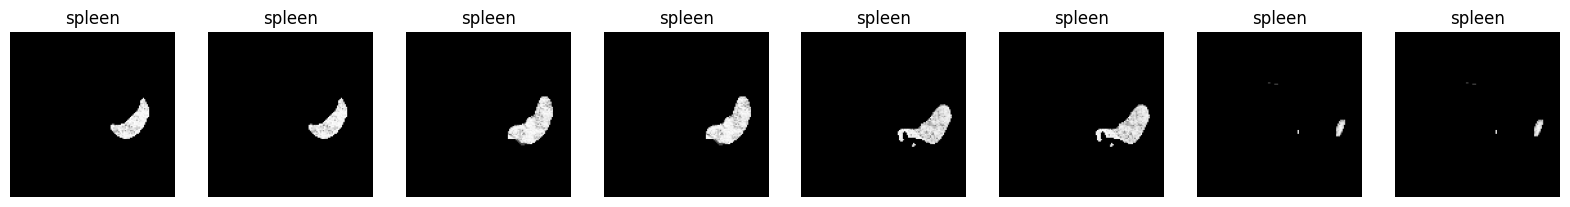

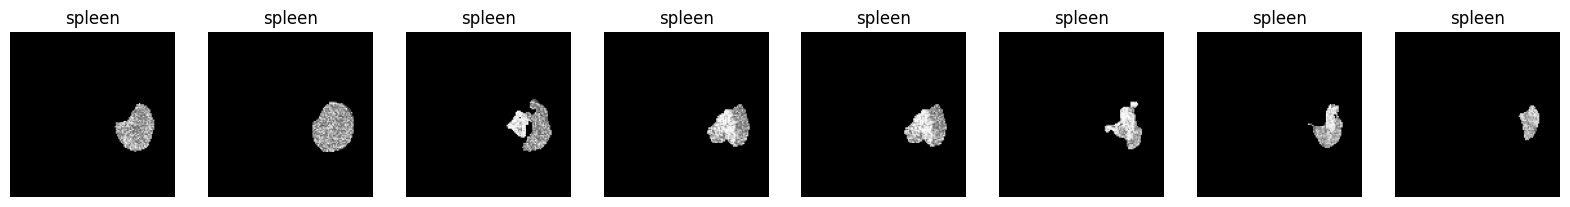

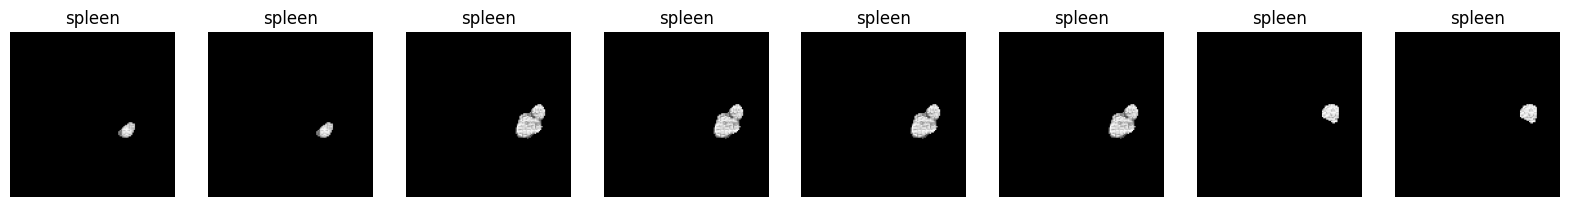

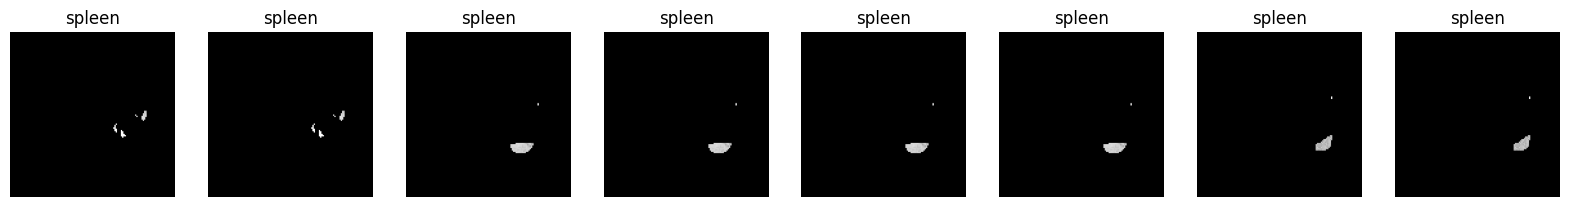

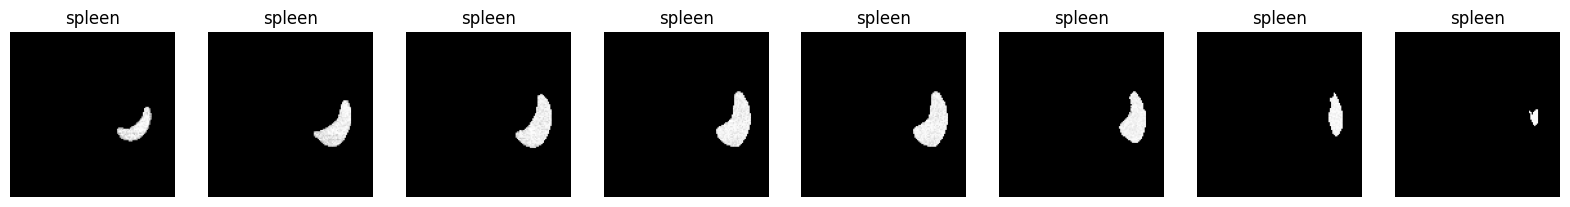

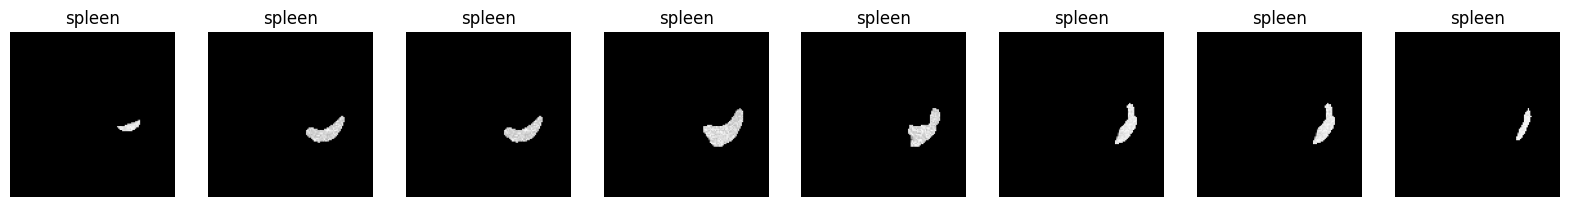

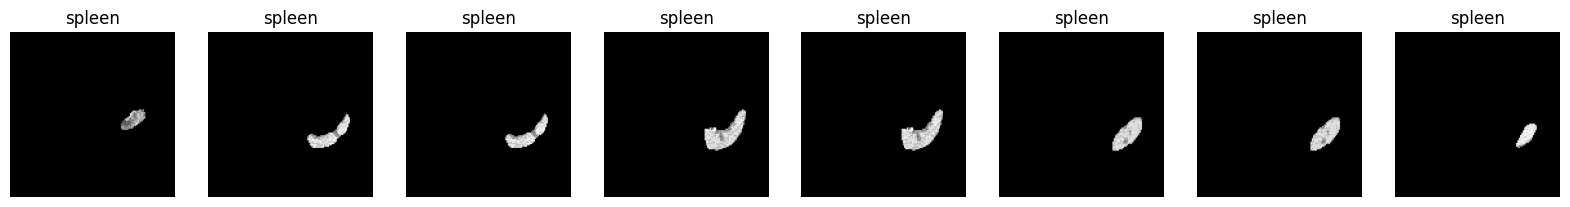

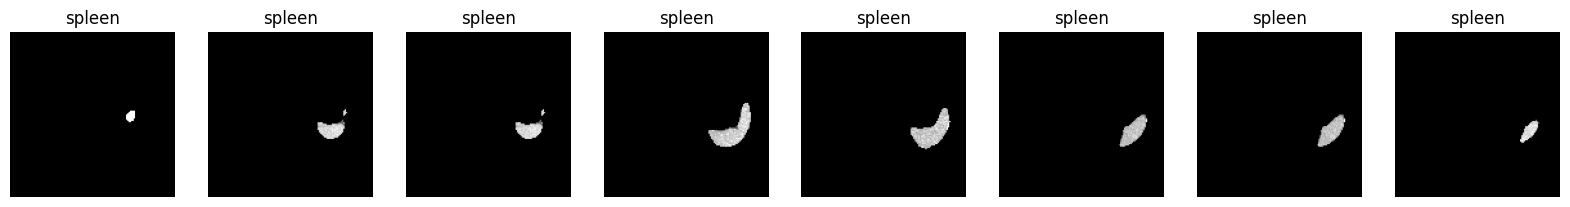

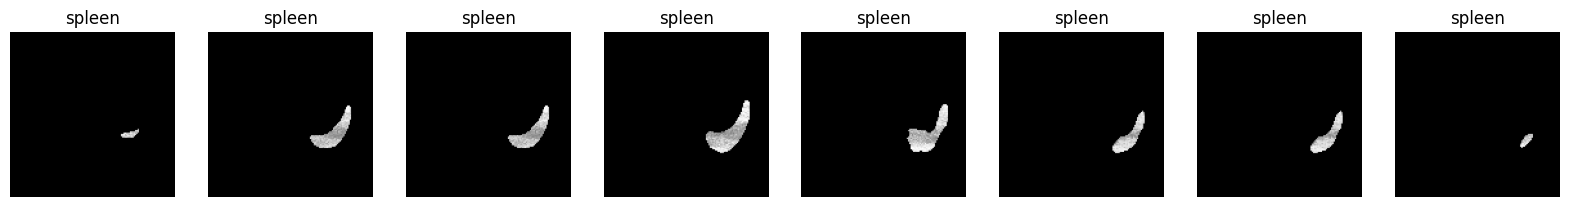

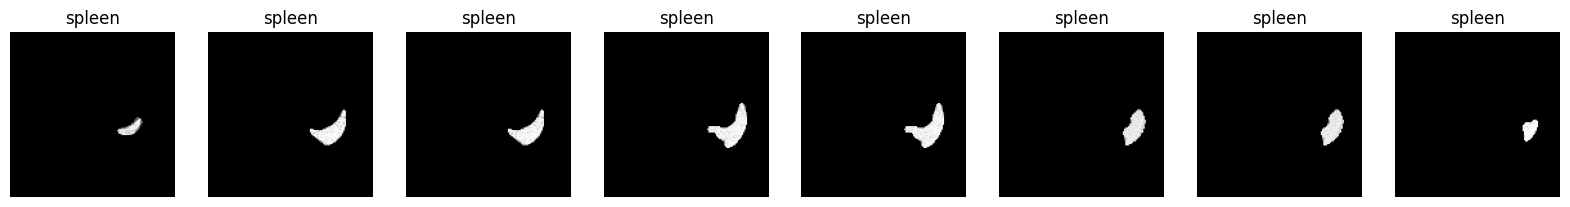

In [19]:
masks, target = next(iter(CNN_validation_dataloader))

num_patients_to_plot = 10

for patient_index in range(0, num_patients_to_plot):
    fig, ax = plt.subplots(1, masks.shape[1], figsize=(20, 15))

    for slice_ind in range( masks.shape[1] ):
        plt.sca(ax[slice_ind])
        plt.imshow(masks[patient_index, slice_ind], cmap='gray')
        plt.axis('off')
        plt.title(organ)

### Define the CNN architecture

In [20]:
class CNN(nn.Module):
    def __init__(self, input_size, output_size, channel_list, dropout_ps, hidden_layer_size):
        super().__init__()
        
        self.dropout_ps = dropout_ps
        self.conv_blocks = nn.ModuleList([
            conv_block(channel_list[i], channel_list[i+1], self.dropout_ps[i])
            for i in range( len( channel_list ) - 1 )
        ])
        self.image_size_after_conv = int(input_size[1] / (2 ** (len(channel_list)-1) ))
        self.l1 = nn.Linear(channel_list[-1] * self.image_size_after_conv ** 2, hidden_layer_size)
        self.l2 = nn.Linear(hidden_layer_size, output_size)
        
    def forward(self, x):
        for conv_block in self.conv_blocks:
            x = conv_block(x)
        
        x = x.reshape(x.shape[0], -1)
        x = f.relu( self.l1(x) )
        x = self.l2(x)
        return x
        
class conv_block(nn.Module):
    def __init__(self, in_channel, out_channel, dropout = None):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channel, out_channel, 3, padding='same', bias=True)
        self.batchnorm1 = nn.BatchNorm2d(out_channel)
        self.conv2 = nn.Conv2d(out_channel, out_channel, 3, padding='same', bias=True)
        self.batchnorm2 = nn.BatchNorm2d(out_channel)
        self.maxpool = nn.MaxPool2d(2)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = self.conv2(x)
        x = self.batchnorm2(x)
        x = self.maxpool(x)
        return x

### Define a class for the overall CNN model containing different CNNs per organ and trainings etc.

In [23]:
class Organ_CNN(nn.Module):
    def __init__(self, cfg, train_ds, val_ds, organ):
        # boilerplate
        super().__init__()
        self.cfg = cfg
        self.organ = organ
        self.output_size = 2 if self.organ in ["bowel", "extravasation"] else 3
        
        if self.organ in ["liver", "kidney", "spleen"]:
            self.weights = torch.tensor([1.0, 2.0, 4.0]).to(self.cfg.device)
        elif self.organ == "bowel":
            self.weights = torch.tensor([1.0, 2.0]).to(self.cfg.device)
        else:
            self.weights = torch.tensor([1.0, 6.0]).to(self.cfg.device)

        self.weights /= self.weights.min()
        
        self.CNN = CNN(input_size=self.cfg.CNN['CNN_inputsize'], output_size=self.output_size, 
                       channel_list=self.cfg.CNN['channel_list'], hidden_layer_size=self.cfg.CNN['hidden_layer'], 
                      dropout_ps=self.cfg.CNN['dropout_ps']).to(self.cfg.device)
        
        self.train_ds = train_ds
        self.val_ds = val_ds
        self.train_dl = torch.utils.data.DataLoader(self.train_ds, batch_size=self.cfg.CNN['batch_size'], shuffle=True)
        self.val_dl = torch.utils.data.DataLoader(self.val_ds, batch_size=self.cfg.CNN['batch_size'], shuffle=False)
        
        self.optim = optim.Adam(self.CNN.parameters(), lr=1e-6, betas=(0.99, 0.999))
        self.lrs = optim.lr_scheduler.LambdaLR(self.optim, lambda x: triangular_lr(x, base_lr=1e-6, triangle_height=1e+3, triangle_width=4 * len(self.train_dl)))
        

    def loss(self, pred, true, output_size=2, weights=None):
        if output_size == 2:
            return f.binary_cross_entropy_with_logits(pred, true, weight=weights)
        else:
            return f.cross_entropy(pred, true, weight=weights)
    
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
                #nn.init.normal_(m.weight.data, 0, 0.02)
                nn.init.kaiming_normal_(m.weight.data)
    
    def train(self):
        train_losses = []
        test_losses = []
        lrs = []
        
        for epoch in range(self.cfg.CNN['n_epochs']):
            gc.collect()
            self.CNN.train()

            running_loss = 0
            for masks, target in self.train_dl:

                # Processing the batch
                images = masks
                targets = target
                images = images.to(self.cfg.device).type(torch.float32)
                targets = targets.to(self.cfg.device).type(torch.float32)
            
                self.optim.zero_grad()
                output = self.CNN(images)
                loss = self.loss(output, targets, output_size=self.output_size, weights=self.weights)
                running_loss += loss.item() * images.shape[0]
                loss.backward()
                self.optim.step()

                lr = self.lrs.get_lr()[0]
                lrs.append(lr)
                self.lrs.step()
                print('.', end='')
            train_losses.append(running_loss / len(self.train_ds))
            

        # --------------------------------- model evaluation
            with torch.no_grad():
                self.CNN.eval()

                running_loss = 0
                for masks, target in self.val_dl:
                    images = masks
                    targets = target
                    images = images.to(self.cfg.device).type(torch.float32)
                    targets = targets.to(self.cfg.device).type(torch.float32)
                    
                    output = self.CNN(images)
                    loss = self.loss(output, targets, output_size=self.output_size, weights=self.weights)
                    running_loss += loss.item() * images.shape[0]
                
                test_losses.append(running_loss / len(self.val_ds))
                print(f'\n[{epoch+1}/{self.cfg.CNN["n_epochs"]}]: {self.organ}: train_loss={train_losses[-1]:0.2f} / test_loss={test_losses[-1]:0.2f} ------------- lr={lrs[-1]:0.8f}\n')
                
        return train_losses, test_losses, lrs
    
    
    def forward(self, data):
        targets = self.CNN(data)
        return targets

In [24]:
liver_model = Organ_CNN(cfg, CNN_train_dataset, CNN_validation_dataset, organ=organ).to(cfg.device)
liver_model.initialize_weights()

In [25]:
train_losses, test_losses, lrs = liver_model.train()

............................|.........|........|..............
[1/50]: spleen: train_loss=2.24 / test_loss=1.62 ------------- lr=0.00050000

...........|...........................|..........|...........
[2/50]: spleen: train_loss=2.11 / test_loss=2.39 ------------- lr=0.00100000

........|..........|...........................|..............
[3/50]: spleen: train_loss=2.01 / test_loss=1.74 ------------- lr=0.00050847

..............................|..............|..........|.....
[4/50]: spleen: train_loss=1.89 / test_loss=1.66 ------------- lr=0.00000847

.....|...............|............|...........................
[5/50]: spleen: train_loss=1.84 / test_loss=1.66 ------------- lr=0.00045000

...................|.|...|....................................
[6/50]: spleen: train_loss=1.76 / test_loss=1.71 ------------- lr=0.00090000

............................|.............|.......|...........
[7/50]: spleen: train_loss=1.59 / test_loss=1.54 ------------- lr=0.00045763

.............

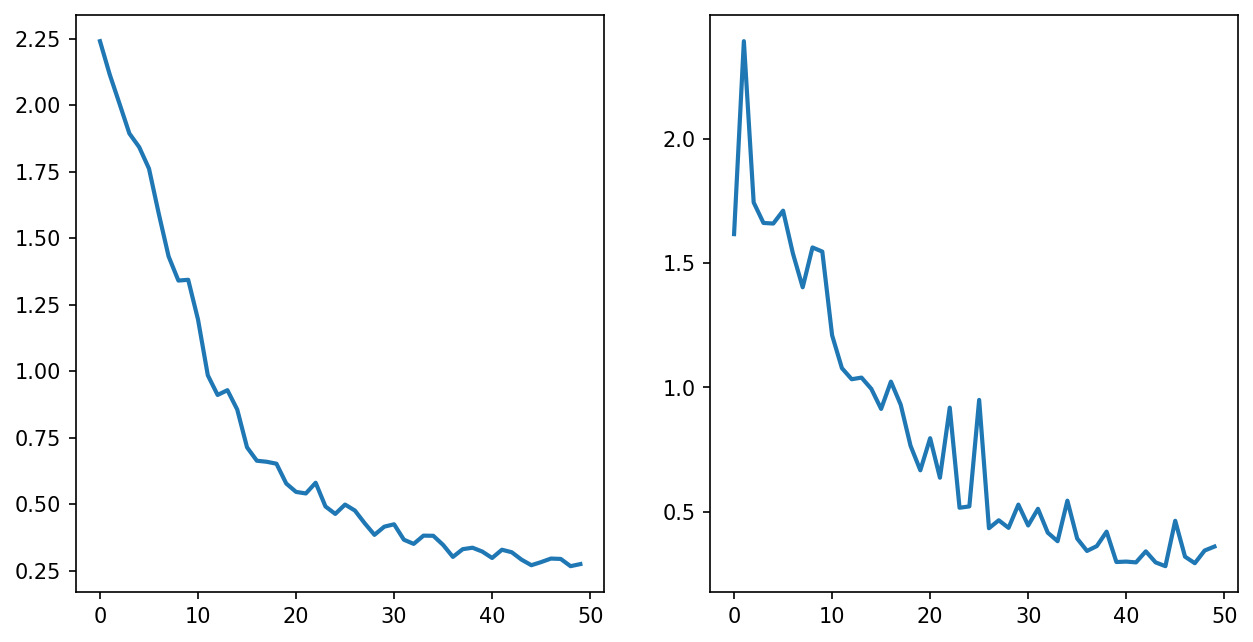

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5), dpi=150)
axs[0].plot(range(len(train_losses)), train_losses, lw=2)
axs[1].plot(range(len(test_losses)), test_losses, lw=2)
plt.show()

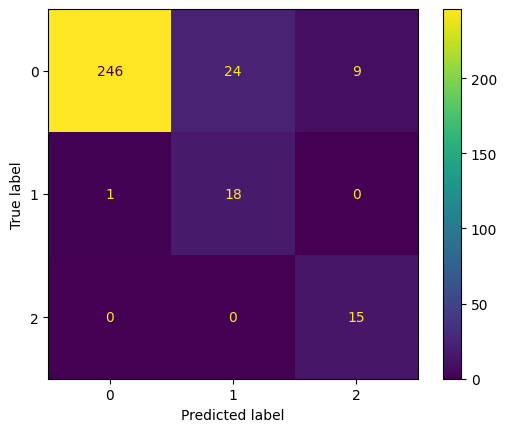

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder

y_true_all = torch.tensor([])
y_pred_all = torch.tensor([])

CNN_confmat_dataloader = DataLoader(CNN_validation_dataset, batch_size=32, shuffle=False)
for masks, targets in CNN_confmat_dataloader:
    y_true = targets.type(torch.int)
    y_true = y_true.argmax(axis=1).view(-1, 1)
    y_pred = f.softmax(liver_model.CNN(masks.to(cfg.device)).detach().cpu())
    y_pred = y_pred.argmax(axis=1).view(-1, 1)
    
    y_true_all = torch.cat([y_true_all, y_true]) if y_true_all.size else y_true
    y_pred_all = torch.cat([y_pred_all, y_pred]) if y_pred_all.size else y_pred
    
cm = confusion_matrix(y_true_all, y_pred_all)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [32]:
torch.save(liver_model.state_dict(), "/kaggle/working/model_spleen.pth")
# torch.save(liver_model, "/kaggle/working/model_spleen.pth")

In [33]:
# testmodel = torch.load('/kaggle/working/model_kidney.pth', map_location=cfg.device)
# _ = testmodel.CNN.eval()

testmodel = Organ_CNN(cfg, CNN_train_dataset, CNN_validation_dataset, organ='spleen').to(cfg.device)
testmodel.load_state_dict( torch.load( '/kaggle/working/model_spleen.pth', map_location=cfg.device ) )
_ = testmodel.CNN.eval()

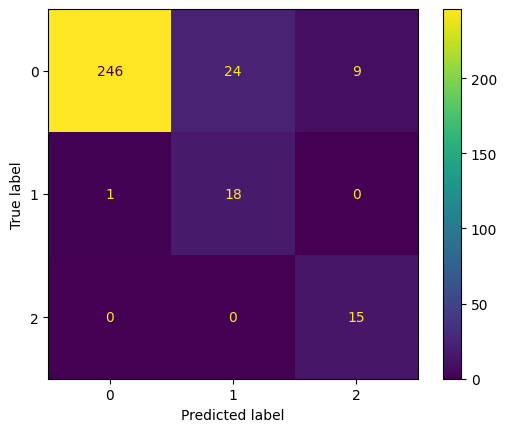

In [34]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder

y_true_all = torch.tensor([])
y_pred_all = torch.tensor([])

CNN_confmat_dataloader = DataLoader(CNN_validation_dataset, batch_size=32, shuffle=False)
for masks, targets in CNN_confmat_dataloader:
    y_true = targets.type(torch.int)
    y_true = y_true.argmax(axis=1).view(-1, 1)
    y_pred = f.softmax(testmodel.CNN(masks.to(cfg.device)).detach().cpu())
    y_pred = y_pred.argmax(axis=1).view(-1, 1)
    
    y_true_all = torch.cat([y_true_all, y_true]) if y_true_all.size else y_true
    y_pred_all = torch.cat([y_pred_all, y_pred]) if y_pred_all.size else y_pred
    
cm = confusion_matrix(y_true_all, y_pred_all)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()